In [1]:
import numpy as np
from osgeo import gdal
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from __future__ import division
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import gridspec
from cartopy.io import shapereader
import shapely.geometry as sgeom

In [3]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [4]:
def saveRaster(path, array, dsSource, datatype=3, formatraster="GTiff", nan=None): 
    """
    Datatypes:
    unknown = 0
    byte = 1
    unsigned int16 = 2
    signed int16 = 3
    unsigned int32 = 4
    signed int32 = 5
    float32 = 6
    float64 = 7
    complex int16 = 8
    complex int32 = 9
    complex float32 = 10
    complex float64 = 11
    float32 = 6, 
    signed int = 3
    
    Formatraster:
    GeoTIFF = GTiff
    Erdas = HFA (output = .img)
    OGC web map service = WMS
    png = PNG
    """
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = dsSource.RasterXSize
    rows = dsSource.RasterYSize
    bands = dsSource.RasterCount
    datatype = datatype#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = dsSource.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = dsSource.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster and write NaN value
    outBand = outDataset.GetRasterBand(1)
    if nan != None:
        outBand.SetNoDataValue(nan)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [5]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [16]:
LST_doy_min = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MIN', extension='.tif'))
LST_doy_max = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MAX', extension='.tif'))
LST_doy_mean = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MEAN', extension='.tif'))
NDVI_doy_min = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MIN', extension='.tif'))
NDVI_doy_max = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MAX', extension='.tif'))
NDVI_doy_mean = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MEAN', extension='.tif'))

In [17]:
nvai_cmap = make_colormap([c('#781800'), c('#B34700'),0.1, c('#B34700'), c('#F09400'),0.2, c('#F09400'), c('#FFBE3B'), 0.3, 
                       c('#FFBE3B'), c('#FFD88A'),0.4, c('#FFD88A'), c('#FFD88A'),0.5, c('#FFFFFF'), c('#B6D676'), 0.6,
                       c('#B6D676'), c('#8BBA2D'),0.7, c('#8BBA2D'), c('#60A100'),0.8, c('#60A100'), c('#1B8500'), 0.9,
                       c('#1B8500'), c('#006915')])

In [18]:
ds = gdal.Open(NDVI_doy_min[0])
print 'geotransform', ds.GetGeoTransform()
print 'raster X size', ds.RasterXSize
print 'raster Y size', ds.RasterYSize

#data_ma = np.ma.masked_equal(NVAI_max,NVAI_max[0][0])
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

#ds = None
gridlons = np.mgrid[xmin:xmax+xres:xres]
gridlats = np.mgrid[ymax+yres:ymin:yres]

geotransform (73.43693268, 0.01, 0.0, 53.57324112, 0.0, -0.01)
raster X size 6163
raster Y size 3537


In [30]:
for idx, file_ in enumerate(NDVI_doy_max[319:320]):
    print idx, file_

0 J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MAX_320.tif


In [32]:
for idx, file_ in enumerate(NDVI_doy_max[319:320]):
    print idx, file_

0 J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MAX_320.tif


In [34]:
NDVI_doy_max[119]

'J:\\MAX_MIN_NDVI_recon_LST_recon\\doy_NDVI\\NDVI_MAX_120.tif'

In [36]:
for idx, file_ in enumerate(NDVI_doy_max[319:320]):
    print idx, file_
    idx = 319
    NDVI_max  = gdal.Open(NDVI_doy_max[idx], gdal.GA_ReadOnly).ReadAsArray()/10000
    NDVI_max  = np.ma.masked_less_equal(NDVI_max,0)
    NDVI_min  = gdal.Open(NDVI_doy_min[idx], gdal.GA_ReadOnly).ReadAsArray()/10000
    NDVI_min  = np.ma.masked_less_equal(NDVI_min,0)
    NDVI_mean = gdal.Open(NDVI_doy_mean[idx], gdal.GA_ReadOnly).ReadAsArray()/10000
    NDVI_mean  = np.ma.masked_less_equal(NDVI_mean,0)
    
    NVAI_max = np.float64((NDVI_max - NDVI_mean) / (NDVI_max - NDVI_min))
    NVAI_min = np.float64((NDVI_min - NDVI_mean) / (NDVI_max - NDVI_min))        

    
#     f= plt.figure()
#     ax = f.add_subplot(111)
#     im = ax.imshow(NVAI_max, cmap=cmap_discretize(nvai_cmap,10),vmin=-1,vmax=1)
#     plt.colorbar(im, fraction=0.0476, pad=0.08, orientation='horizontal')
#     text_plot =  ('MAX DOY'+str(idx+1).zfill(3)+'\n'+'mean: '+str(np.round(NVAI_max.mean(),2))+'\n'+
#                   'max:  '+str(np.round(NVAI_max.max(),2))+'\n'+'min:  '+str(np.round(NVAI_max.min(),2)))

#     plt.text(0.9, 0.1,text_plot, ha='center', va='center', transform=ax.transAxes)    
#     plt.tight_layout()
#     plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png\min_max_doy//MAX_doy_'+str(idx+1).zfill(3)+'.png',dpi=200)    
#     plt.clf()
#     plt.close()    
#     #NVAI_max = None
    

#     f= plt.figure()
#     ax = f.add_subplot(111)
#     im = ax.imshow(NVAI_min, cmap=cmap_discretize(nvai_cmap,10),vmin=-1,vmax=1)
#     plt.colorbar(im, fraction=0.0476, pad=0.08, orientation='horizontal')
#     text_plot =  ('MIN DOY'+str(idx+1).zfill(3)+'\n'+'mean: '+str(np.round(NVAI_min.mean(),2))+'\n'+
#                   'max:  '+str(np.round(NVAI_min.max(),2))+'\n'+'min:  '+str(np.round(NVAI_min.min(),2)))

#     plt.text(0.9, 0.1,text_plot, ha='center', va='center', transform=ax.transAxes)    
#     plt.tight_layout()
#     plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png\min_max_doy//MIN_doy_'+str(idx+1).zfill(3)+'.png',dpi=200)    
#     plt.clf()
#     plt.close()  
    #NVAI_min = None
    
    
    fname = r'D:\Data\ChinaShapefile\CHN_adm//CHN_adm1.shp'
    fig = plt.figure(figsize=(12,12))
    #extent = [gridlons.min(), gridlons.max(),gridlats.min(),gridlats.max()]
    extent = [73.5,140,14,53.6]
    #img_extent = (73.5,140,14,53.6)
    # PLOT CENTER
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=100, central_latitude=15))
    ax.set_extent(extent)
    coastline = cfeature.COASTLINE.scale='50m'
    borders = cfeature.BORDERS.scale='50m'

    gl = ax.gridlines()
    gl.xlocator = mticker.FixedLocator([50, 70,90,110,130,150,170])
    gl.ylocator = mticker.FixedLocator([10,  20,  30,  40,  50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.85',zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2, edgecolor='black',zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor='black',zorder=1)
    ax.add_geometries(Reader(fname).geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none', linewidth=0.2,edgecolor='black',zorder=2)

    #ax.imshow(np.flipud(data_ma), extent = img_extent, transform=ccrs.PlateCarree())
    im = plt.pcolormesh(gridlons, gridlats, NVAI_max, transform=ccrs.PlateCarree(), vmin=0, vmax=1, zorder=1, 
                        cmap=cmap_discretize(nvai_cmap,10))#, norm=norm, cmap=cmap)

    cb = plt.colorbar(im, fraction=0.0476, pad=0.04, orientation='horizontal')#, ticks=bounds,norm=norm
    text_plot =  ('MAX DOY'+str(idx+1).zfill(3)+'\n'+'mean: '+str(np.round(NVAI_max.mean(),2))+'\n'+
                  'max:  '+str(np.round(NVAI_max.max(),2))+'\n'+'min:  '+str(np.round(NVAI_max.min(),2)))

    plt.text(0.9, 0.1,text_plot, ha='center', va='center', transform=ax.transAxes)
    plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png\min_max_doy//1MAX_doy_'+str(idx+1).zfill(3)+'.png',dpi=200)
    plt.clf()
    plt.close()

    fname = r'D:\Data\ChinaShapefile\CHN_adm//CHN_adm1.shp'
    fig = plt.figure(figsize=(12,12))
    #extent = [gridlons.min(), gridlons.max(),gridlats.min(),gridlats.max()]
    extent = [73.5,140,14,53.6]
    #img_extent = (73.5,140,14,53.6)
    # PLOT CENTER
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=100, central_latitude=15))
    ax.set_extent(extent)
    coastline = cfeature.COASTLINE.scale='50m'
    borders = cfeature.BORDERS.scale='50m'

    gl = ax.gridlines()
    gl.xlocator = mticker.FixedLocator([50, 70,90,110,130,150,170])
    gl.ylocator = mticker.FixedLocator([10,  20,  30,  40,  50, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, facecolor='0.85',zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2, edgecolor='black',zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.2, edgecolor='black',zorder=1)
    ax.add_geometries(Reader(fname).geometries(),
                      ccrs.PlateCarree(),
                      facecolor='none', linewidth=0.2,edgecolor='black',zorder=2)

    #ax.imshow(np.flipud(data_ma), extent = img_extent, transform=ccrs.PlateCarree())
    im = plt.pcolormesh(gridlons, gridlats, NVAI_min, transform=ccrs.PlateCarree(), vmin=-1, vmax=0, zorder=1, 
                        cmap=cmap_discretize(nvai_cmap,10))#, norm=norm, cmap=cmap)

    cb = plt.colorbar(im, fraction=0.0476, pad=0.04, orientation='horizontal')#, ticks=bounds,norm=norm
    text_plot =  ('MIN DOY'+str(idx+1).zfill(3)+'\n'+'mean: '+str(np.round(NVAI_min.mean(),2))+'\n'+
                  'max:  '+str(np.round(NVAI_min.max(),2))+'\n'+'min:  '+str(np.round(NVAI_min.min(),2)))

    plt.text(0.9, 0.1,text_plot, ha='center', va='center', transform=ax.transAxes)
    plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png\min_max_doy//1MIN_doy_'+str(idx+1).zfill(3)+'.png',dpi=200)
    plt.clf()
    plt.close()

0 J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MAX_320.tif


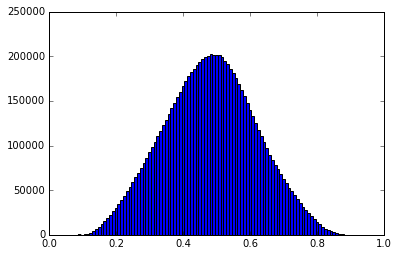

In [40]:
plt.hist(NVAI_max.compressed(),bins=100)
plt.show()

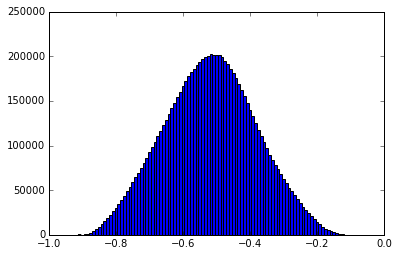

In [41]:
plt.hist(NVAI_min.compressed(),bins=100)
plt.show()